### 오픈데이터 모든 측정소 데이터

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns

import math, time
from sklearn.metrics import mean_squared_error

# 스케일링 패키지 (Min_max_scaler)
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

# 그래프 관련 패키지
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# tensorflow 패키지 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import * 

In [2]:
# 1.데이터 로드 부분 

kwater=pd.read_csv()
kwater.head()

,No,연도,월,조사회차,채수 일자,수계 명,중권역 명,측정소 명,수심,음이온계면활성제(ABS),...,부유물질(SS),트리클로로에틸렌(TCE),총대장균군,수온,총질소(T-N),총유기탄소(TOC),총인(T-P),투명도,아연(Zn),CNT
0,91,2016,1,1회차 상층부,2016.01.05,금강,대청댐,대청댐1,0.2,NaN,...,1.3,NaN,6.0,7.8,0.821,2.0,0.009,3.3,NaN,1
1,92,2016,1,1회차 상층부,2016.01.05,금강,대청댐,대청댐5,1.0,NaN,...,1.2,NaN,0.0,7.0,1.776,1.5,0.010,4.8,NaN,1
2,93,2016,1,1회차 상층부,2016.01.05,금강,대청댐,대청댐6,1.0,NaN,...,1.4,NaN,0.0,7.0,1.821,1.6,0.015,4.3,NaN,1
3,94,2016,1,1회차 상층부,2016.01.05,금강,대청댐,대청댐2,1.0,NaN,...,1.2,NaN,0.0,7.0,2.389,1.4,0.007,2.0,NaN,1
4,95,2016,1,1회차 상층부,2016.01.05,금강,대청댐,대청댐3,1.0,NaN,...,1.6,NaN,0.0,7.0,1.861,1.4,0.015,2.3,NaN,1


In [3]:
# 2.분석에 필요한 컬럼 select 
kwater_df= kwater[[' 채수 일자',' 수심', '생물화학적산소요구량(BOD)', '클로로필-a(Chlorophyll-a)', '화학적산소요구량(COD)', '용존산소(DO)', '용존총질소(DTN)', '용존총인(DTP)', '전기전도도(EC)', '분원성대장균군', '암모니아성 질소(NH3-N)', '질산성질소(NO3-N)', '수소이온농도(pH)', '인산염 인(PO4-P)', '부유물질(SS)', '총대장균군', '수온', '총질소(T-N)', '총유기탄소(TOC)', '총인(T-P)']]

In [4]:
# 3.결측치 보간: 선형보간법 적용
for col in kwater_df.columns:
    kwater_df[col] = kwater_df[col].interpolate(method='linear')

C:\Users\user\AppData\Local\Temp/ipykernel_7604/1144726440.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kwater_df[col] = kwater_df[col].interpolate(method='linear')


In [5]:
# 4. 채수일자 index 변환
kwater_df[' 채수 일자'] = pd.to_datetime(kwater_df[' 채수 일자'])
kwater_df = kwater_df.set_index([' 채수 일자'])

C:\Users\user\AppData\Local\Temp/ipykernel_7604/1686479702.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kwater_df[' 채수 일자'] = pd.to_datetime(kwater_df[' 채수 일자'])


In [6]:
# 5.스케일링 Min-max scalering 
min_max_scaler =preprocessing.MinMaxScaler(feature_range = (0, 1))
dataset = min_max_scaler.fit_transform(kwater_df['클로로필-a(Chlorophyll-a)'].values.reshape(-1,1))

In [7]:
# split into train and test sets [7:3]
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1435 616


In [8]:
# 원데이터,train/test 데이터 변수 확인
print(len(kwater_df))
print(1435+616)

2051
2051


In [9]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=3):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [10]:
x_train, y_train = create_dataset(train, look_back=3)
x_test, y_test = create_dataset(test, look_back=3)

In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1431, 3)
(1431,)
(612, 3)
(612,)


In [12]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

In [13]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1431, 1, 3)
(1431,)
(612, 1, 3)
(612,)


In [14]:
# create and fit the LSTM network
look_back = 3
model = Sequential()
model.add(LSTM(20, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=20, batch_size=13, verbose=2)

Epoch 1/20
111/111 - 2s - loss: 0.0022 - 2s/epoch - 19ms/step
Epoch 2/20
111/111 - 0s - loss: 0.0018 - 206ms/epoch - 2ms/step
Epoch 3/20
111/111 - 0s - loss: 0.0017 - 216ms/epoch - 2ms/step
Epoch 4/20
111/111 - 0s - loss: 0.0017 - 212ms/epoch - 2ms/step
Epoch 5/20
111/111 - 0s - loss: 0.0016 - 208ms/epoch - 2ms/step
Epoch 6/20
111/111 - 0s - loss: 0.0016 - 242ms/epoch - 2ms/step
Epoch 7/20
111/111 - 0s - loss: 0.0016 - 223ms/epoch - 2ms/step
Epoch 8/20
111/111 - 0s - loss: 0.0016 - 255ms/epoch - 2ms/step
Epoch 9/20
111/111 - 0s - loss: 0.0016 - 378ms/epoch - 3ms/step
Epoch 10/20
111/111 - 0s - loss: 0.0016 - 277ms/epoch - 2ms/step
Epoch 11/20
111/111 - 0s - loss: 0.0016 - 206ms/epoch - 2ms/step
Epoch 12/20
111/111 - 0s - loss: 0.0016 - 211ms/epoch - 2ms/step
Epoch 13/20
111/111 - 0s - loss: 0.0016 - 228ms/epoch - 2ms/step
Epoch 14/20
111/111 - 0s - loss: 0.0016 - 296ms/epoch - 3ms/step
Epoch 15/20
111/111 - 0s - loss: 0.0016 - 323ms/epoch - 3ms/step
Epoch 16/20
111/111 - 0s - loss: 0.0

In [15]:
trainPredict = model.predict(x_train)
testPredict = model.predict(x_test)
# invert predictions
trainPredict = min_max_scaler.inverse_transform(trainPredict)
trainY = min_max_scaler.inverse_transform([y_train])
testPredict = min_max_scaler.inverse_transform(testPredict)
testY = min_max_scaler.inverse_transform([y_test])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

20/20 [==============================] - 0s 2ms/step
Train Score: 4.40 RMSE
Test Score: 7.18 RMSE


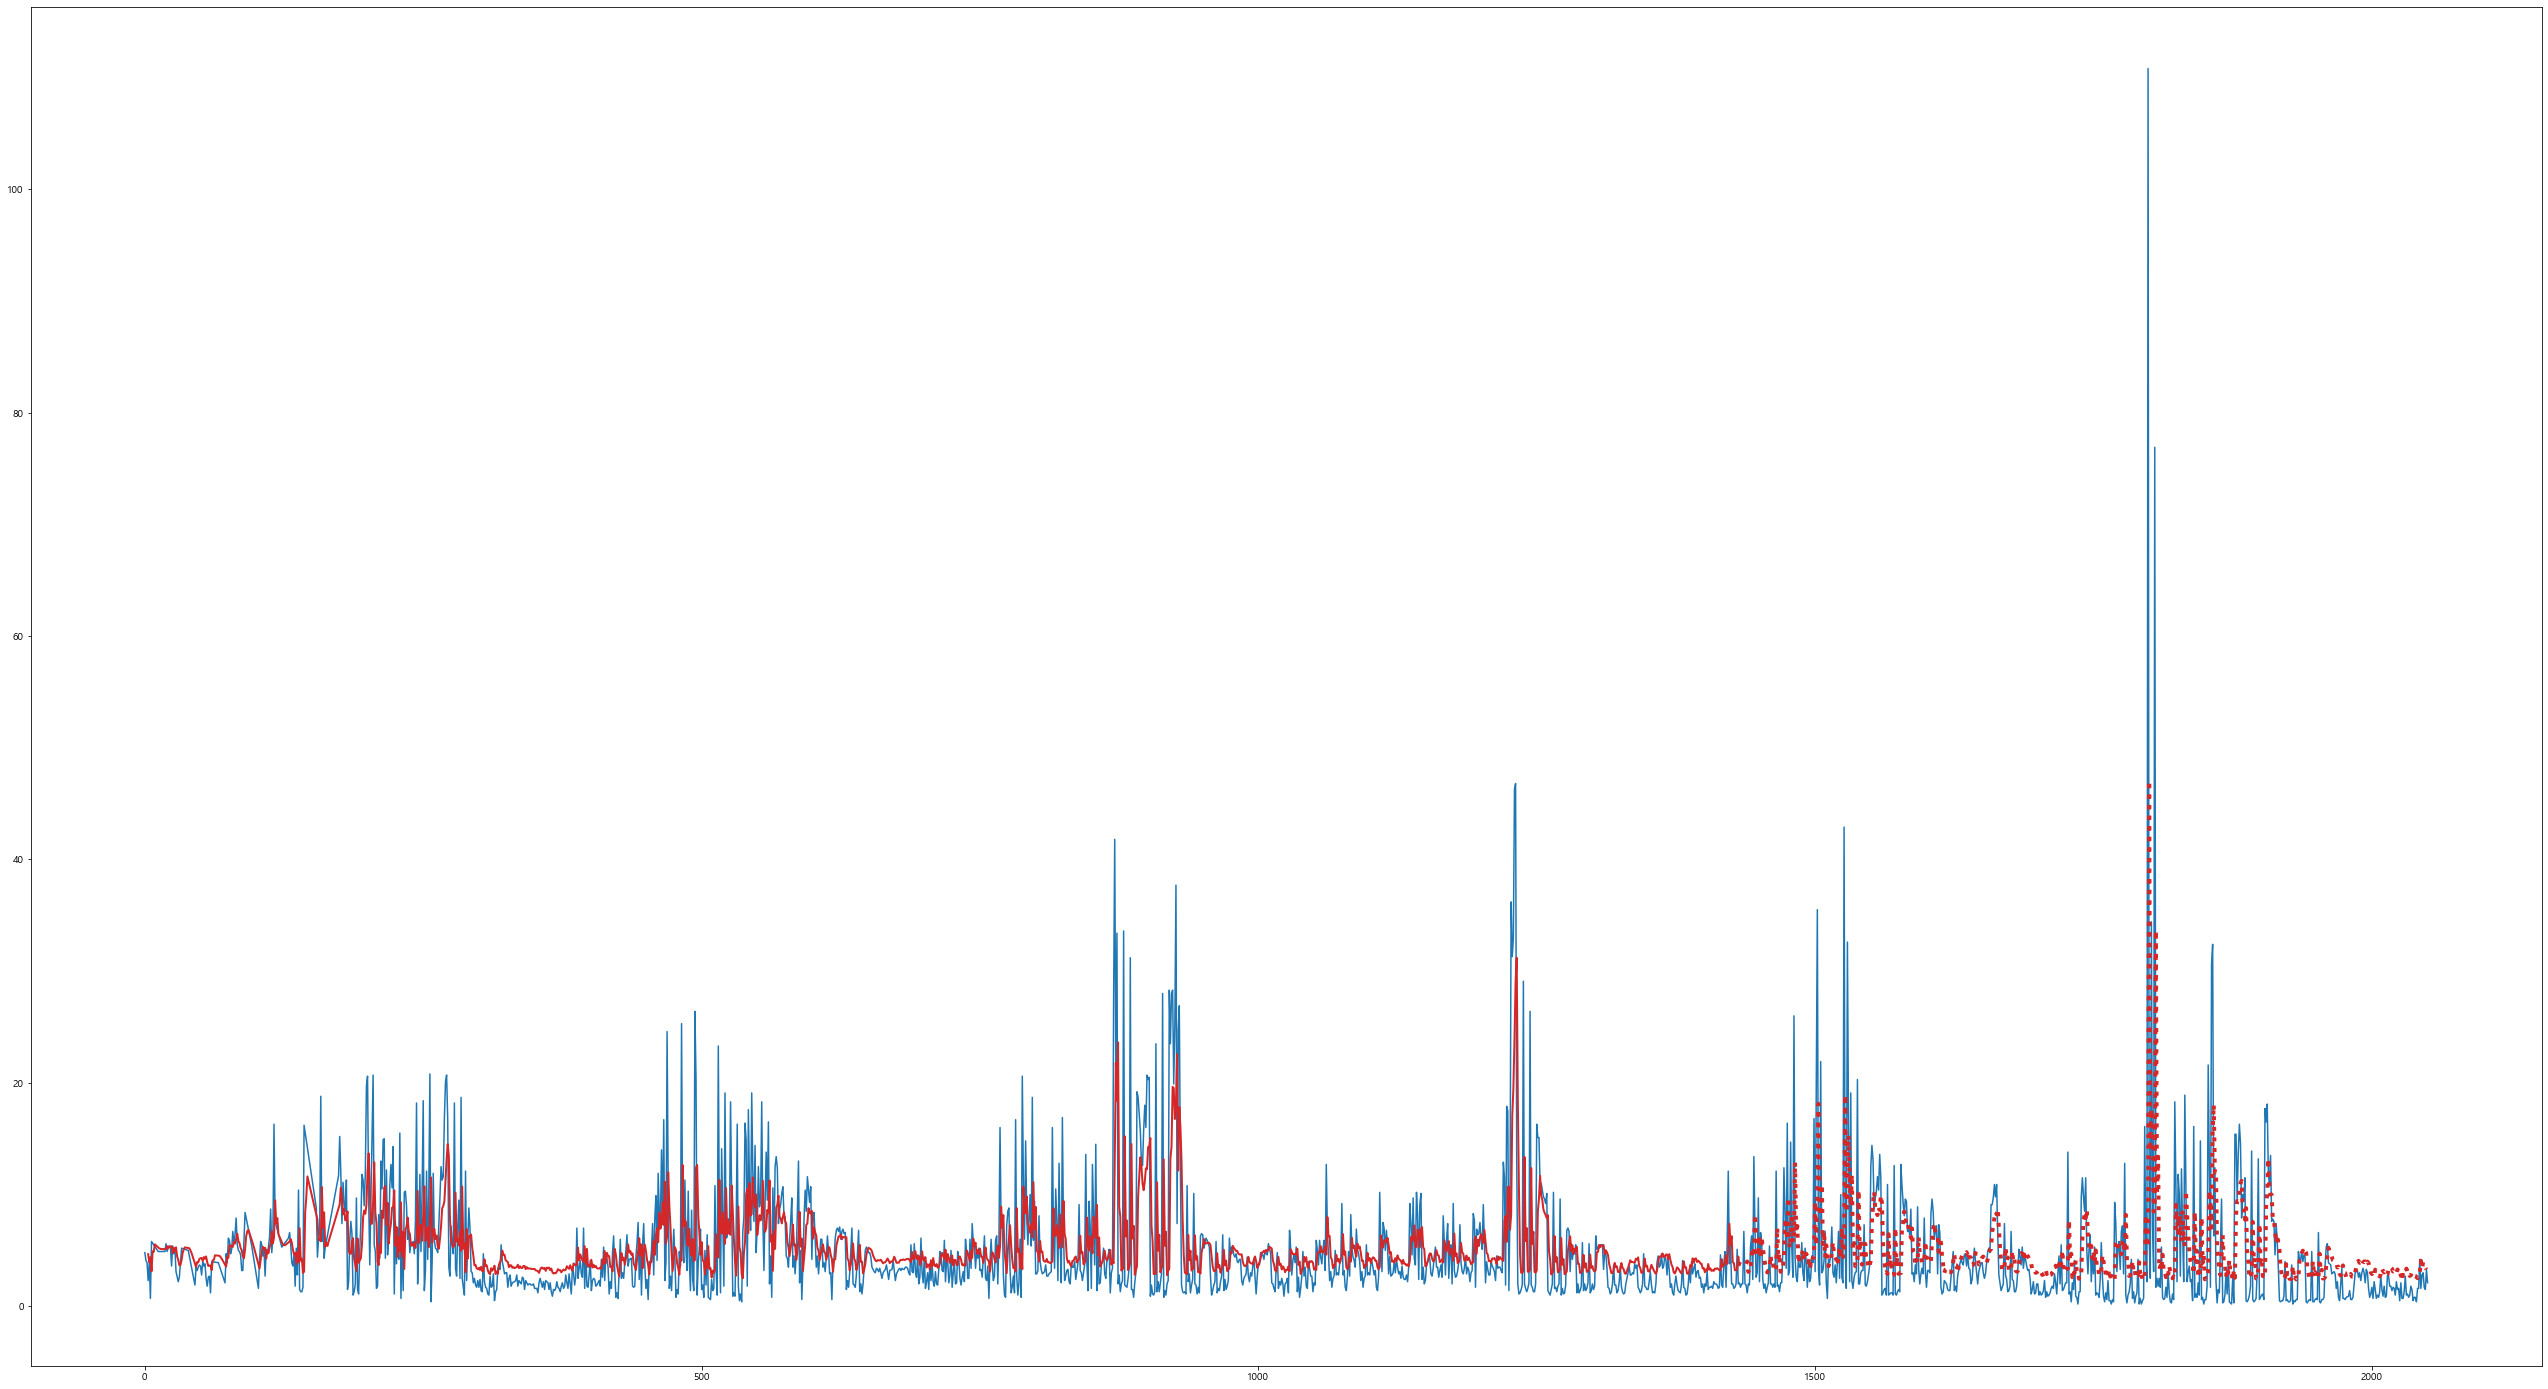

In [16]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(45,25))
plt.plot(min_max_scaler.inverse_transform(dataset))
plt.plot((trainPredictPlot),color= 'tab:red', linestyle='-', linewidth='2')
plt.plot((testPredictPlot),color= 'tab:red', linestyle=':', linewidth='4')
plt.show()

###### 측정소에 따라 데이터를 나누지 않을 경우 trend는 잡을 수 있지만 값이 극단적으로 변하는 것을 잡지 못한다.

### 대청댐1 데이터 선택 LSTM
    - 0.5 이하 상층권 데이터 분석

In [17]:
# 수심에 따른 카테고리 변수 생성 
# 상층권 0.5 이하 / 중층권 5이상 11이하 / 하층권 12이상 에 따른 범주 데이터 생성

grades = [] #리스트 생성
for row in kwater[' 수심'] : 
    if row <= 0.5:
        grades.append('상층권')
    elif 5 <= row <=11:
        grades.append('중층권')
    else :
        grades.append('하층권')

kwater['grade'] = grades

In [18]:
## 측정소 명에 따른 분류 
kwater_select_1 = kwater[kwater[' 측정소 명']=='대청댐1']
kwater_select_2 = kwater[kwater[' 측정소 명']=='대청댐2']
kwater_select_3 = kwater[kwater[' 측정소 명']=='대청댐3']
kwater_select_4 = kwater[kwater[' 측정소 명']=='대청댐4']
kwater_select_5 = kwater[kwater[' 측정소 명']=='대청댐5']
kwater_select_6 = kwater[kwater[' 측정소 명']=='대청댐6']

print('='*50)
print('대청댐1:',kwater_select_1.shape)
print('대청댐2:',kwater_select_2.shape)
print('대청댐3:',kwater_select_3.shape)
print('대청댐4:',kwater_select_4.shape)
print('대청댐5:',kwater_select_5.shape)
print('대청댐6:',kwater_select_6.shape)

대청댐1: (911, 65)
대청댐2: (228, 65)
대청댐3: (228, 65)
대청댐4: (228, 65)
대청댐5: (228, 65)
대청댐6: (228, 65)


In [19]:
# 측정소 : 대청댐 1 데이터 사용
kwater_data_1 = kwater_select_1[[' 채수 일자', ' 수심', '생물화학적산소요구량(BOD)', '염소이온(Cl-)', '클로로필-a(Chlorophyll-a)', '화학적산소요구량(COD)', '다이에틸헥실프탈레이트(DEHP)', '용존산소(DO)', '용존총질소(DTN)', '용존총인(DTP)', '전기전도도(EC)', '분원성대장균군', '암모니아성 질소(NH3-N)', '질산성질소(NO3-N)', '수소이온농도(pH)', '인산염 인(PO4-P)', '부유물질(SS)', '총대장균군', '수온', '총질소(T-N)', '총유기탄소(TOC)', '총인(T-P)','grade']]

# 채수일자 object 변수 -> datetime 변경 
kwater_data_1[' 채수 일자'] = pd.to_datetime(kwater_data_1[' 채수 일자'])
# 데이터 타입 확인
kwater_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 0 to 2050
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0    채수 일자                 911 non-null    datetime64[ns]
 1    수심                    911 non-null    float64       
 2   생물화학적산소요구량(BOD)        911 non-null    float64       
 3   염소이온(Cl-)              860 non-null    float64       
 4   클로로필-a(Chlorophyll-a)  911 non-null    float64       
 5   화학적산소요구량(COD)          911 non-null    float64       
 6   다이에틸헥실프탈레이트(DEHP)      860 non-null    float64       
 7   용존산소(DO)               911 non-null    float64       
 8   용존총질소(DTN)             910 non-null    float64       
 9   용존총인(DTP)              911 non-null    float64       
 10  전기전도도(EC)              911 non-null    float64       
 11  분원성대장균군                911 non-null    float64       
 12  암모니아성 질소(NH3-N)        908 non-null    float64       
 13  질산성질

C:\Users\user\AppData\Local\Temp/ipykernel_7604/4208542840.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kwater_data_1[' 채수 일자'] = pd.to_datetime(kwater_data_1[' 채수 일자'])


In [20]:
### 염소이온 / 다이에틸헥실프탈레이트 -> 기입 수치 값이 0으로 되어 있어서 제외 [칼럼 19개]
kwater_data_1= kwater_data_1[[' 채수 일자', ' 수심', '생물화학적산소요구량(BOD)', '클로로필-a(Chlorophyll-a)', '화학적산소요구량(COD)', '용존산소(DO)', '용존총질소(DTN)', '용존총인(DTP)', '전기전도도(EC)', '분원성대장균군', '암모니아성 질소(NH3-N)', '질산성질소(NO3-N)', '수소이온농도(pH)', '인산염 인(PO4-P)', '부유물질(SS)', '총대장균군', '수온', '총질소(T-N)', '총유기탄소(TOC)', '총인(T-P)','grade']]
kwater_data_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 911 entries, 0 to 2050
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0    채수 일자                 911 non-null    datetime64[ns]
 1    수심                    911 non-null    float64       
 2   생물화학적산소요구량(BOD)        911 non-null    float64       
 3   클로로필-a(Chlorophyll-a)  911 non-null    float64       
 4   화학적산소요구량(COD)          911 non-null    float64       
 5   용존산소(DO)               911 non-null    float64       
 6   용존총질소(DTN)             910 non-null    float64       
 7   용존총인(DTP)              911 non-null    float64       
 8   전기전도도(EC)              911 non-null    float64       
 9   분원성대장균군                911 non-null    float64       
 10  암모니아성 질소(NH3-N)        908 non-null    float64       
 11  질산성질소(NO3-N)           911 non-null    float64       
 12  수소이온농도(pH)             911 non-null    float64       
 13  인산염 

In [21]:
# 채수 일자 -> inedx로 변환 
kwater_data_1[' 채수 일자'] = pd.to_datetime(kwater_data_1[' 채수 일자'])
kwater_data_1 = kwater_data_1.set_index([' 채수 일자'])

In [22]:
# grade 데이터 형태에 따른 데이터 갯수 확인
kwater_up = kwater_data_1[kwater_data_1[' 수심']<=0.5]
kwater_mid = kwater_data_1[(5<= kwater_data_1[' 수심']) & (kwater_data_1[' 수심']<=11)]
kwater_bottom = kwater_data_1[kwater_data_1[' 수심'] >=12]
print('상층권 데이터 개수:' , kwater_up.shape)
print('중층권 데이터 개수:' , kwater_mid.shape)
print('하층권 데이터 개수:' , kwater_bottom.shape)

상층권 데이터 개수: (313, 20)
중층권 데이터 개수: (300, 20)
하층권 데이터 개수: (298, 20)


In [23]:
# grade 컬럼 drop
kwater_up = kwater_up.drop(["grade"],axis=1)
kwater_up.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 313 entries, 2016-01-05 to 2022-04-25
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0    수심                    313 non-null    float64
 1   생물화학적산소요구량(BOD)        313 non-null    float64
 2   클로로필-a(Chlorophyll-a)  313 non-null    float64
 3   화학적산소요구량(COD)          313 non-null    float64
 4   용존산소(DO)               313 non-null    float64
 5   용존총질소(DTN)             312 non-null    float64
 6   용존총인(DTP)              313 non-null    float64
 7   전기전도도(EC)              313 non-null    float64
 8   분원성대장균군                313 non-null    float64
 9   암모니아성 질소(NH3-N)        312 non-null    float64
 10  질산성질소(NO3-N)           313 non-null    float64
 11  수소이온농도(pH)             313 non-null    float64
 12  인산염 인(PO4-P)           313 non-null    float64
 13  부유물질(SS)               313 non-null    float64
 14  총대장균군                  313 non-null    

In [24]:
# 스케일링 Min-max scalering 
min_max_scaler =preprocessing.MinMaxScaler(feature_range = (0, 1))
dataset_up = min_max_scaler.fit_transform(kwater_up['클로로필-a(Chlorophyll-a)'].values.reshape(-1,1))

In [25]:
# split into train and test sets [70:30]
train_up_size = int(len(dataset_up) * 0.7)
test_up_size = len(dataset_up) - train_up_size
train_up, test_up = dataset[0:train_up_size,:], dataset[train_up_size:len(dataset_up),:]
print(len(train_up), len(test_up))

219 94


In [26]:
# 상층권 데이터 , train/test 데이터 개수 확인
print(len(kwater_up))
print(219+94)

313
313


In [27]:
# convert an array of values into a dataset matrix
def create_dataset(dataset_up, look_back=3):
    data_up_X, data_up_Y = [], []
    for i in range(len(dataset_up)-look_back-1):
        a = dataset_up[i:(i+look_back), 0]
        data_up_X.append(a)
        data_up_Y.append(dataset_up[i + look_back, 0])
    return np.array(data_up_X), np.array(data_up_Y)

In [28]:
x_train_up, y_train_up = create_dataset(train_up, look_back=3)
x_test_up, y_test_up = create_dataset(test_up, look_back=3)

In [29]:
print(x_train_up.shape)
print(y_train_up.shape)
print(x_test_up.shape)
print(y_test_up.shape)

(215, 3)
(215,)
(90, 3)
(90,)


In [30]:
x_train_up = np.reshape(x_train_up, (x_train_up.shape[0], 1, x_train_up.shape[1]))
x_test_up = np.reshape(x_test_up, (x_test_up.shape[0], 1, x_test_up.shape[1]))

In [31]:
# (samples, time steps, features)
print(x_train_up.shape)
print(y_train_up.shape)
print(x_test_up.shape)
print(y_test_up.shape)

(215, 1, 3)
(215,)
(90, 1, 3)
(90,)


In [32]:
# create and fit the LSTM network
look_back = 3
model_up = Sequential()
model_up.add(LSTM(20, input_shape=(1, look_back)))
model_up.add(Dense(1))
model_up.compile(loss='mean_squared_error', optimizer='adam')
model_up.fit(x_train_up, y_train_up, epochs=20, batch_size=1, verbose=2)

# plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
# plt.title('model loss')
# plt.ylabel('loss')
# plt.xlable('epoch')
# plt.lengnd(['train_up', 'test_up'], loc= 'upper right')
# plt.show()

Epoch 1/20
215/215 - 1s - loss: 0.0013 - 1s/epoch - 7ms/step
Epoch 2/20
215/215 - 0s - loss: 0.0011 - 303ms/epoch - 1ms/step
Epoch 3/20
215/215 - 0s - loss: 9.9406e-04 - 290ms/epoch - 1ms/step
Epoch 4/20
215/215 - 0s - loss: 9.2731e-04 - 297ms/epoch - 1ms/step
Epoch 5/20
215/215 - 0s - loss: 9.0370e-04 - 314ms/epoch - 1ms/step
Epoch 6/20
215/215 - 0s - loss: 8.6925e-04 - 312ms/epoch - 1ms/step
Epoch 7/20
215/215 - 0s - loss: 8.2946e-04 - 313ms/epoch - 1ms/step
Epoch 8/20
215/215 - 0s - loss: 8.4397e-04 - 325ms/epoch - 2ms/step
Epoch 9/20
215/215 - 0s - loss: 8.1643e-04 - 319ms/epoch - 1ms/step
Epoch 10/20
215/215 - 0s - loss: 8.0466e-04 - 376ms/epoch - 2ms/step
Epoch 11/20
215/215 - 0s - loss: 8.1262e-04 - 346ms/epoch - 2ms/step
Epoch 12/20
215/215 - 0s - loss: 8.0063e-04 - 493ms/epoch - 2ms/step
Epoch 13/20
215/215 - 0s - loss: 7.9373e-04 - 379ms/epoch - 2ms/step
Epoch 14/20
215/215 - 0s - loss: 8.0329e-04 - 408ms/epoch - 2ms/step
Epoch 15/20
215/215 - 0s - loss: 8.2406e-04 - 302ms/ep

In [33]:
trainPredict_up = model.predict(x_train_up)
testPredict_up = model.predict(x_test_up)
# invert predictions
trainPredict_up = min_max_scaler.inverse_transform(trainPredict_up)
train_up_Y = min_max_scaler.inverse_transform([y_train_up])
testPredict_up = min_max_scaler.inverse_transform(testPredict_up)
test_up_Y = min_max_scaler.inverse_transform([y_test_up])
# calculate root mean squared error
trainScore_up = math.sqrt(mean_squared_error(train_up_Y[0], trainPredict_up[:,0]))
print('Train Score_up: %.2f RMSE' % (trainScore_up))
testScore_up = math.sqrt(mean_squared_error(test_up_Y[0], testPredict_up[:,0]))
print('Test Score_up : %.2f RMSE' % (testScore_up))

3/3 [==============================] - 0s 2ms/step
Train Score_up: 3.05 RMSE
Test Score_up : 5.12 RMSE


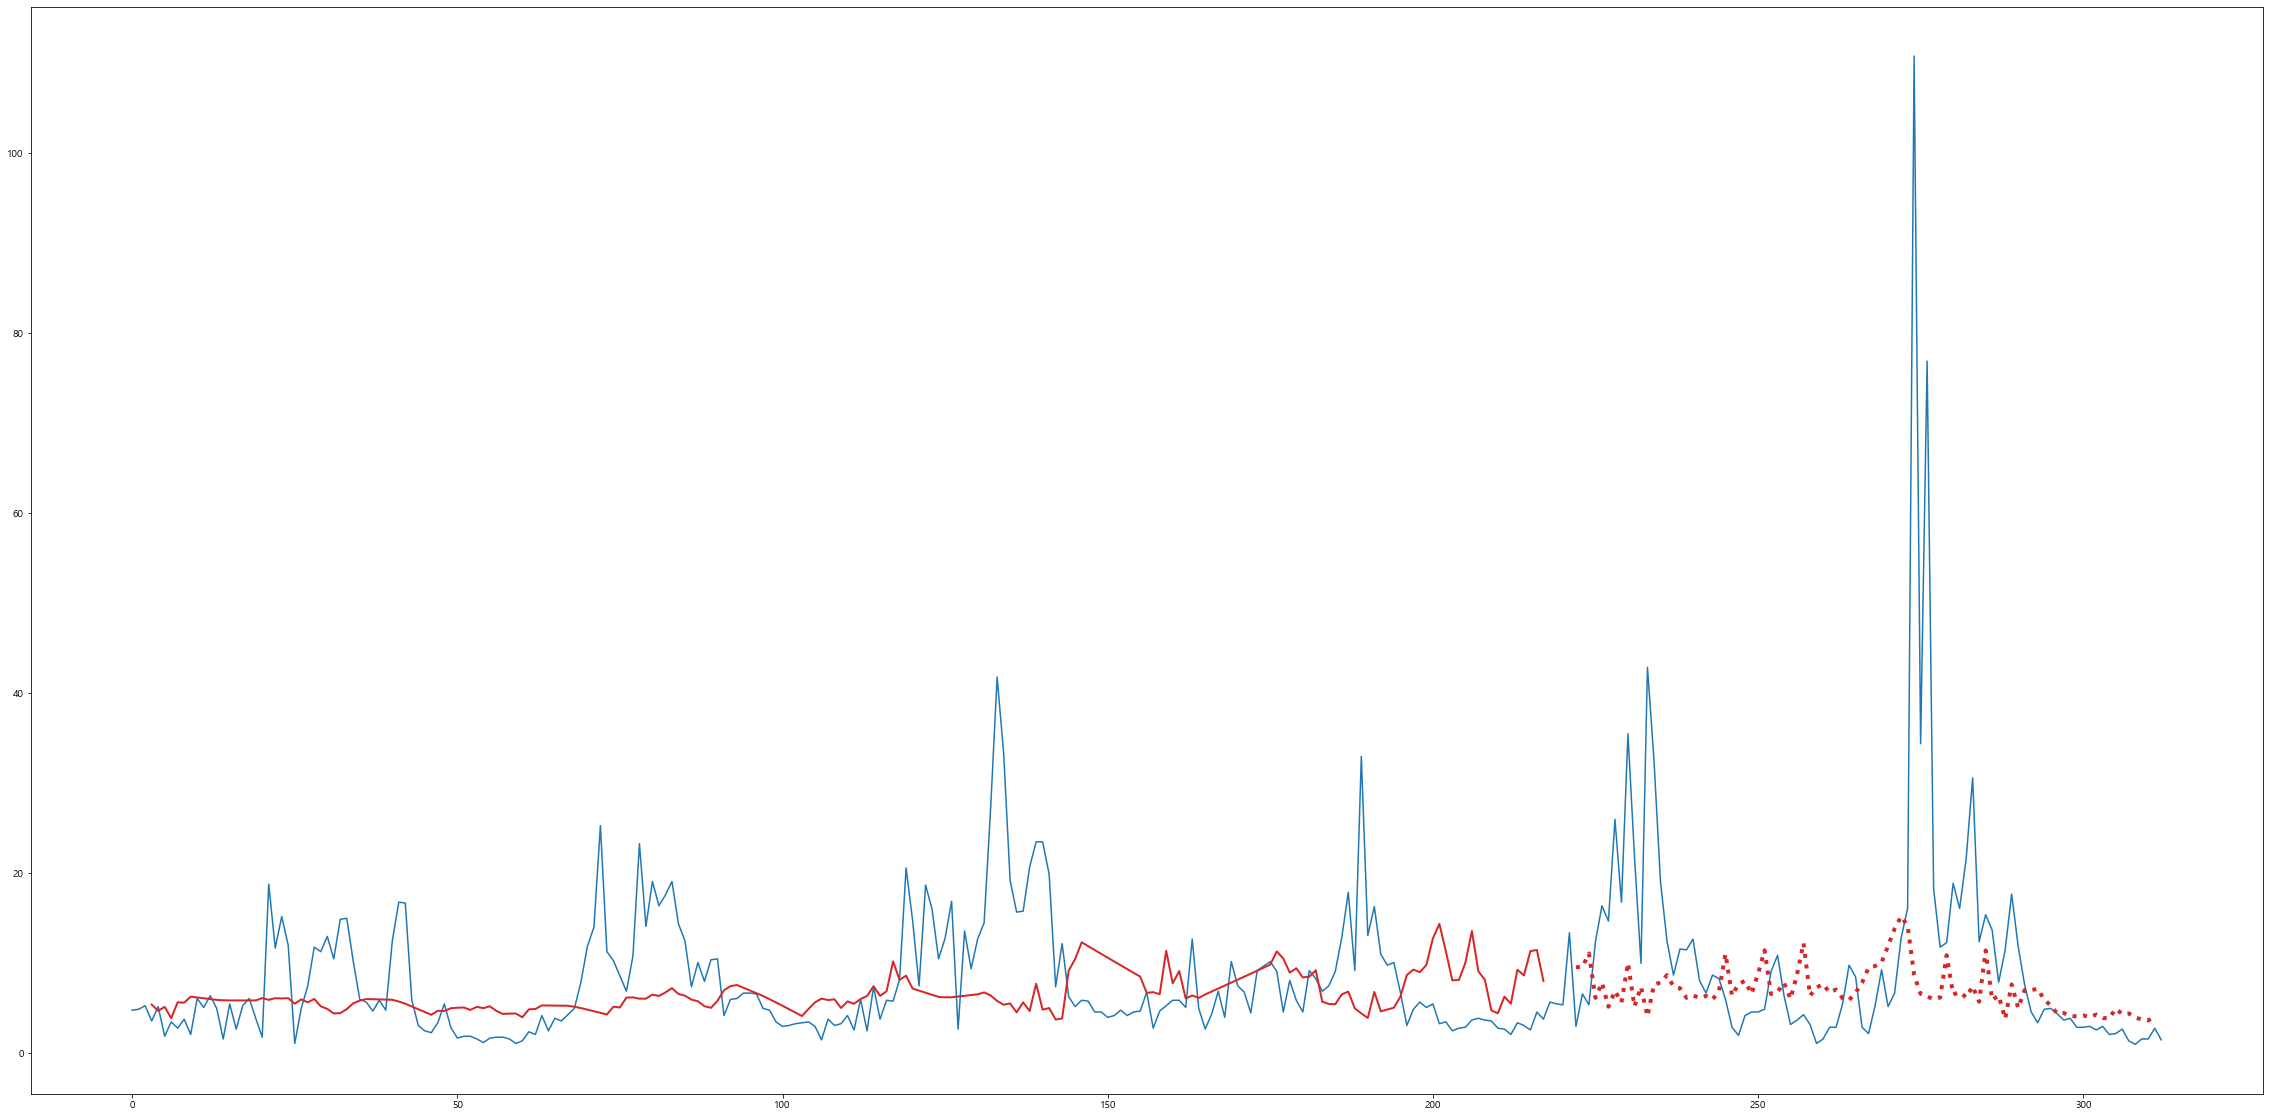

In [34]:
# shift train predictions for plotting
trainPredictPlot_up = np.empty_like(dataset_up)
trainPredictPlot_up[:, :] = np.nan
trainPredictPlot_up[look_back:len(trainPredict_up)+look_back, :] = trainPredict_up
# shift test predictions for plotting
testPredictPlot_up = np.empty_like(dataset_up)
testPredictPlot_up[:, :] = np.nan
testPredictPlot_up[len(trainPredict_up)+(look_back*2)+1:len(dataset_up)-1, :] = testPredict_up
# plot baseline and predictions
plt.figure(figsize=(40,20))
plt.plot(min_max_scaler.inverse_transform(dataset_up))
plt.plot((trainPredictPlot_up),color= 'tab:red', linestyle='-', linewidth='2')
plt.plot((testPredictPlot_up),color= 'tab:red', linestyle=':', linewidth='4')
plt.show()